# 기본 설정

In [ ]:
!pip install SQLAlchemy pymysql
from google.colab import userdata

from sqlalchemy import create_engine, text
engine = create_engine("mysql+pymysql://user:password@공개IP/goyong")



# 접속 정보 설정
user = 'root'               # Cloud SQL 사용자 이름
password = userdata.get('DB')       # 비밀번호
host = '34.47.81.137'           # 예: 34.64.xxx.xxx
database = 'goyong'           # 사용할 DB 이름

# SQLAlchemy 접속 URL 구성
url = f"mysql+pymysql://{user}:{password}@{host}/{database}"
engine = create_engine(url)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.8 MB/s eta 0:00:00


In [ ]:
import kagglehub

path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")
path+='/Rice_Image_Dataset'
print("Path to dataset files:", path)

100%|██████████| 219M/219M [00:02<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import Adam
from torch.optim import AdamW
from tqdm.auto import tqdm
from timeit import default_timer as timer
import os
import copy

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:

!pip install split-folders

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# TensorBoard 로그 저장 디렉토리 지정
writer = SummaryWriter("runs/experiment_1")


In [ ]:
import splitfolders  # splitfolders 라이브러리 불러오기

splitfolders.ratio(
    path,  # 원본 데이터 폴더 경로
    output="splitted",  # 분할된 데이터가 저장될 폴더명 (기본값: "splitted")
    seed=1337,  # 랜덤 시드 값 (재현 가능성 보장)
    ratio=(0.8, 0, 0.2)  # 훈련 80%, 검증 0%, 테스트 20% 비율로 데이터 분할
)


Copying files: 75000 files [00:10, 7418.32 files/s]


In [ ]:
test_data_path = '/content/splitted/test'
train_data_path = '/content/splitted/train'
classes = [dir for dir in os.listdir(test_data_path)]

In [ ]:
classes

['Karacadag', 'Basmati', 'Jasmine', 'Ipsala', 'Arborio']

In [ ]:
def training(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = 0
    train_acc = 0

    for batch, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)

        label_pred = model(image)

        loss = loss_fn(label_pred,label)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        label_pred_class = torch.argmax(torch.softmax(label_pred, dim=1), dim=1)
        train_acc += (label_pred_class == label).sum().item()/len(label_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def train_process(model, train_dataloader, optimizer, loss_fn, epochs):
    results = {"train_loss": [], "train_acc": []}


    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)

        # TensorBoard에 Loss & Accuracy 기록
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Accuracy/train", train_acc, epoch)

        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f}")


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

    writer.close()  # TensorBoard Writer 종료
    return results

In [ ]:
def test_step(model,dataloader,loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            test_loss += loss.item()
            val_pred_labels = val_pred_logits.argmax(dim=1)
            test_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# 변형을 줬을 때

In [ ]:
train_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset_rn50 = datasets.ImageFolder(root=train_data_path, transform=train_transform_rn50)
test_dataset_rn50 = datasets.ImageFolder(root=test_data_path, transform=test_transform_rn50)
est_data_loader = DataLoader(test_dataset_rn50, batch_size=32, shuffle=True)
train_data_loader = DataLoader(train_dataset_rn50, batch_size=32, shuffle=True)
rn50_model = resnet50(weights=ResNet50_Weights.DEFAULT)
rn50_model.fc = nn.Sequential(nn.Linear(in_features=rn50_model.fc.in_features, out_features=5))
for param in rn50_model.parameters():
    param.requires_grad = False

for param in rn50_model.fc.parameters():
    param.requires_grad = True

rn50_model = rn50_model.to(device)
rn50_model2 = copy.deepcopy(rn50_model).to(device)
rn50_model3 = copy.deepcopy(rn50_model).to(device)
loss_fn = nn.CrossEntropyLoss()
optim_rn50 = Adam(params=rn50_model.parameters(), lr=0.001)

In [ ]:
import time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

start_time = timer()

rn50_results = train_process(model=rn50_model,train_dataloader=train_data_loader,optimizer=optim_rn50,loss_fn=loss_fn,epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2271 | train_acc: 0.9453
Epoch: 2 | train_loss: 0.0967 | train_acc: 0.9709
Epoch: 3 | train_loss: 0.0788 | train_acc: 0.9747
Epoch: 4 | train_loss: 0.0712 | train_acc: 0.9765
Epoch: 5 | train_loss: 0.0659 | train_acc: 0.9779
Epoch: 6 | train_loss: 0.0623 | train_acc: 0.9788
Epoch: 7 | train_loss: 0.0611 | train_acc: 0.9789
Epoch: 8 | train_loss: 0.0610 | train_acc: 0.9793
Epoch: 9 | train_loss: 0.0566 | train_acc: 0.9811
Epoch: 10 | train_loss: 0.0548 | train_acc: 0.9815
Total Training Time: 1661.867 seconds


In [ ]:
test_step(model=rn50_model, dataloader=test_data_loader, loss_fn=loss_fn)

(0.04530902666552092, 0.9856743070362474)

# 변형 지우고

In [ ]:
train_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_rn50)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_rn50)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
rn50_model2 = resnet50(weights=ResNet50_Weights.DEFAULT)
rn50_model2.fc = nn.Sequential(nn.Linear(in_features=rn50_model2.fc.in_features, out_features=5))
for param in rn50_model2.parameters():
    param.requires_grad = False

for param in rn50_model2.fc.parameters():
    param.requires_grad = True

rn50_model2 = rn50_model2.to(device)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = Adam(params=rn50_model2.parameters(), lr=0.001)

In [ ]:
import time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

start_time = timer()

rn50_result = train_process(model=rn50_model2,train_dataloader=train_loader,optimizer=optim,loss_fn=loss_fn,epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1938 | train_acc: 0.9630
Epoch: 2 | train_loss: 0.0667 | train_acc: 0.9817
Epoch: 3 | train_loss: 0.0502 | train_acc: 0.9856
Epoch: 4 | train_loss: 0.0444 | train_acc: 0.9865
Epoch: 5 | train_loss: 0.0391 | train_acc: 0.9880
Epoch: 6 | train_loss: 0.0344 | train_acc: 0.9898
Epoch: 7 | train_loss: 0.0344 | train_acc: 0.9890
Epoch: 8 | train_loss: 0.0326 | train_acc: 0.9892
Epoch: 9 | train_loss: 0.0312 | train_acc: 0.9899
Epoch: 10 | train_loss: 0.0296 | train_acc: 0.9903
Total Training Time: 1546.139 seconds


In [ ]:
test_step(model=rn50_model2, dataloader=test_loader, loss_fn=loss_fn)

(0.02224624726760225, 0.9930037313432836)

이 또한 변형이 없을 때 더 일반화 성능이 높은 것을 볼 수 있다 그렇다면 회전 증강방법은 쓰면 안되는 것인가? 이 문제는 각도에 따라서 실험을 해야한다.

# 변형 30도

In [ ]:
train_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_rn50)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_rn50)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
rn50_model2 = resnet50(weights=ResNet50_Weights.DEFAULT)
rn50_model2.fc = nn.Sequential(nn.Linear(in_features=rn50_model2.fc.in_features, out_features=5))
for param in rn50_model2.parameters():
    param.requires_grad = False

for param in rn50_model2.fc.parameters():
    param.requires_grad = True

rn50_model2 = rn50_model2.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = Adam(params=rn50_model2.parameters(), lr=0.001)

In [ ]:
import time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

start_time = timer()

rn50_result = train_process(model=rn50_model2,train_dataloader=train_loader,optimizer=optim,loss_fn=loss_fn,epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2231 | train_acc: 0.9474
Epoch: 2 | train_loss: 0.0955 | train_acc: 0.9706
Epoch: 3 | train_loss: 0.0753 | train_acc: 0.9762
Epoch: 4 | train_loss: 0.0700 | train_acc: 0.9768
Epoch: 5 | train_loss: 0.0642 | train_acc: 0.9786
Epoch: 6 | train_loss: 0.0621 | train_acc: 0.9795
Epoch: 7 | train_loss: 0.0588 | train_acc: 0.9802
Epoch: 8 | train_loss: 0.0590 | train_acc: 0.9801
Epoch: 9 | train_loss: 0.0559 | train_acc: 0.9811
Epoch: 10 | train_loss: 0.0522 | train_acc: 0.9820
Total Training Time: 1719.493 seconds


In [ ]:
test_step(model=rn50_model2, dataloader=test_loader, loss_fn=loss_fn)

(0.04106270601433803, 0.9859408315565032)

30도로 했을 때도 성능이 45도 했을 때와 비슷하다 15 도까지만 더 추가 연구를 하고 다른 변환 방법을 적용하여 연구를 할 생각이다

# 변형 15도

In [ ]:
train_15 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_15 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_15)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_15)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
rn50_15 = resnet50(weights=ResNet50_Weights.DEFAULT)
rn50_15.fc = nn.Sequential(nn.Linear(in_features=rn50_15.fc.in_features, out_features=5))
for param in rn50_15.parameters():
    param.requires_grad = False

for param in rn50_15.fc.parameters():
    param.requires_grad = True

rn50_15 = rn50_15.to(device)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = Adam(params=rn50_15.parameters(), lr=0.001)

In [ ]:
import time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

start_time = timer()

rn50_result = train_process(model=rn50_15,train_dataloader=train_loader,optimizer=optim,loss_fn=loss_fn,epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2135 | train_acc: 0.9517
Epoch: 2 | train_loss: 0.0875 | train_acc: 0.9740
Epoch: 3 | train_loss: 0.0691 | train_acc: 0.9784
Epoch: 4 | train_loss: 0.0631 | train_acc: 0.9794
Epoch: 5 | train_loss: 0.0587 | train_acc: 0.9805
Epoch: 6 | train_loss: 0.0555 | train_acc: 0.9812
Epoch: 7 | train_loss: 0.0541 | train_acc: 0.9822
Epoch: 8 | train_loss: 0.0515 | train_acc: 0.9829
Epoch: 9 | train_loss: 0.0505 | train_acc: 0.9831
Epoch: 10 | train_loss: 0.0482 | train_acc: 0.9833
Total Training Time: 1693.287 seconds


In [ ]:
test_step(model=rn50_15, dataloader=test_loader, loss_fn=loss_fn)

(0.035313550031372605, 0.988339552238806)

In [ ]:
rn50_result

{'train_loss': [0.21346342677871386,
  0.08748214978997906,
  0.06913947416270773,
  0.06310580610111356,
  0.058714964948222044,
  0.05546731738553693,
  0.054075249746876455,
  0.05147468105809142,
  0.05048726601346085,
  0.04819778904064248],
 'train_acc': [0.9517,
  0.9740333333333333,
  0.97835,
  0.9793833333333334,
  0.9805,
  0.98125,
  0.9821833333333333,
  0.9828666666666667,
  0.9830833333333333,
  0.9832666666666666]}

15도 역시 회전시 훈련셋 98% 정확도를 가지고 테스트셋으로는 (0.035313550031372605, 0.988339552238806) 의 성능을 보여준다 이 또한 회전을 안 했을 때 더 좋은 성능을 보인다는 것을 입증한다

그렇다면 회전으로는 이 데이터들의 일반화 성능을 올릴 수 없나?

보간 법과 패딩을 검은색이 아닌 흰 색으로 할 예정이다.

#DB 연결 및 저장

In [ ]:
# with engine.connect() as conn:
#     # Use text() to create a SQLAlchemy TextClause object
#     conn.execute(text("""
#         CREATE TABLE IF NOT EXISTS training_metrics (
#             id INT AUTO_INCREMENT PRIMARY KEY,
#             rotation INT NOT NULL,
#             epoch INT NOT NULL,
#             train_loss FLOAT,
#             train_acc FLOAT
#         );
#     """))

In [ ]:
with engine.connect() as conn:
    for epoch, (loss, acc) in enumerate(zip(rn50_result['train_loss'], rn50_result['train_acc']), start=1):
        values_to_insert = {
            'rotation': 15,
            'epoch': epoch,
            'train_loss': loss,
            'train_acc': acc
        }
        conn.execute(
            text("INSERT INTO training_metrics (rotation, epoch, train_loss, train_acc) VALUES (:rotation, :epoch, :train_loss, :train_acc)"),
            values_to_insert
        )
    conn.commit()

In [ ]:
with engine.connect() as conn:
    result = conn.execute(text("SELECT * FROM training_metrics"))

    # 결과 출력
    for row in result.fetchall():
        print(row)

(1, 15, 1, 0.213463, 0.9517)
(2, 15, 2, 0.0874821, 0.974033)
(3, 15, 3, 0.0691395, 0.97835)
(4, 15, 4, 0.0631058, 0.979383)
(5, 15, 5, 0.058715, 0.9805)
(6, 15, 6, 0.0554673, 0.98125)
(7, 15, 7, 0.0540752, 0.982183)
(8, 15, 8, 0.0514747, 0.982867)
(9, 15, 9, 0.0504873, 0.983083)
(10, 15, 10, 0.0481978, 0.983267)


# 보간법

In [ ]:
train_IN = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(degrees=15, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_IN = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_IN)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_IN)

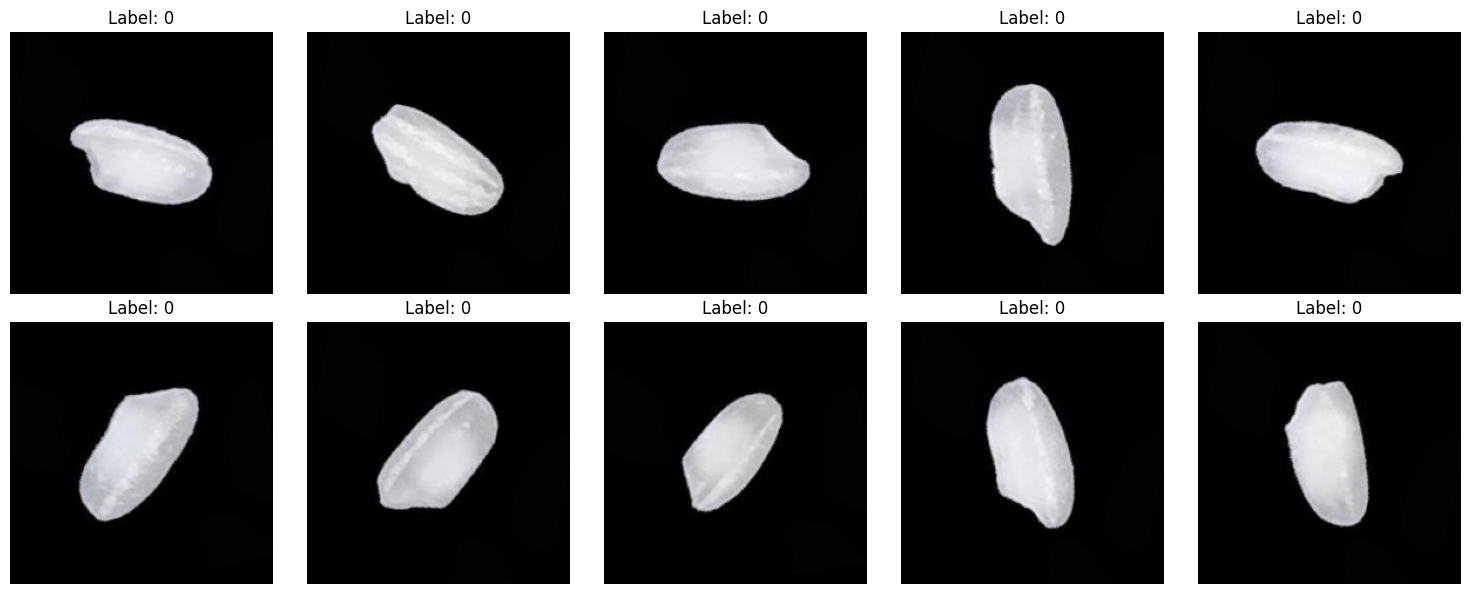

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# 이미지 여러 장 꺼내서 시각화
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
for i in range(10):
    img_tensor, label = train_dataset[i]  # transform까지 적용된 이미지
    img_tensor = inv_normalize(img_tensor)  # 정규화 해제
    img_np = img_tensor.permute(1, 2, 0).clamp(0, 1).numpy()

    ax = axs[i // 5][i % 5]
    ax.imshow(img_np)
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
rn50_IN = resnet50(weights=ResNet50_Weights.DEFAULT)
rn50_IN.fc = nn.Sequential(nn.Linear(in_features=rn50_IN.fc.in_features, out_features=5))
for param in rn50_IN.parameters():
    param.requires_grad = False

for param in rn50_IN.fc.parameters():
    param.requires_grad = True

rn50_IN = rn50_IN.to(device)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = Adam(params=rn50_IN.parameters(), lr=0.001)

In [ ]:
import time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

start_time = timer()

rn_in_result = train_process(model=rn50_IN,train_dataloader=train_loader,optimizer=optim,loss_fn=loss_fn,epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1951 | train_acc: 0.9604
Epoch: 2 | train_loss: 0.0713 | train_acc: 0.9799
Epoch: 3 | train_loss: 0.0566 | train_acc: 0.9825
Epoch: 4 | train_loss: 0.0503 | train_acc: 0.9843
Epoch: 5 | train_loss: 0.0451 | train_acc: 0.9854
Epoch: 6 | train_loss: 0.0421 | train_acc: 0.9867
Epoch: 7 | train_loss: 0.0422 | train_acc: 0.9859
Epoch: 8 | train_loss: 0.0394 | train_acc: 0.9871
Epoch: 9 | train_loss: 0.0398 | train_acc: 0.9861
Epoch: 10 | train_loss: 0.0359 | train_acc: 0.9883
Total Training Time: 2541.625 seconds


In [ ]:
test_step(model=rn50_IN, dataloader=test_loader, loss_fn=loss_fn)

(0.08105263183675786, 0.9717928216062544)

보간법도 비슷한 결과를 보여준다 아마 이유는 이미 이미지가 전처리가 되어 있어서 보간을 해도 검은색 같은 결과를 보여주는 것 같다.

#패딩

In [ ]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode

train_P = transforms.Compose([
    transforms.Resize(size=232),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(
        degrees=15,
        fill=(255, 255, 255)  # R, G, B 흰색 패딩
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_P)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_IN)

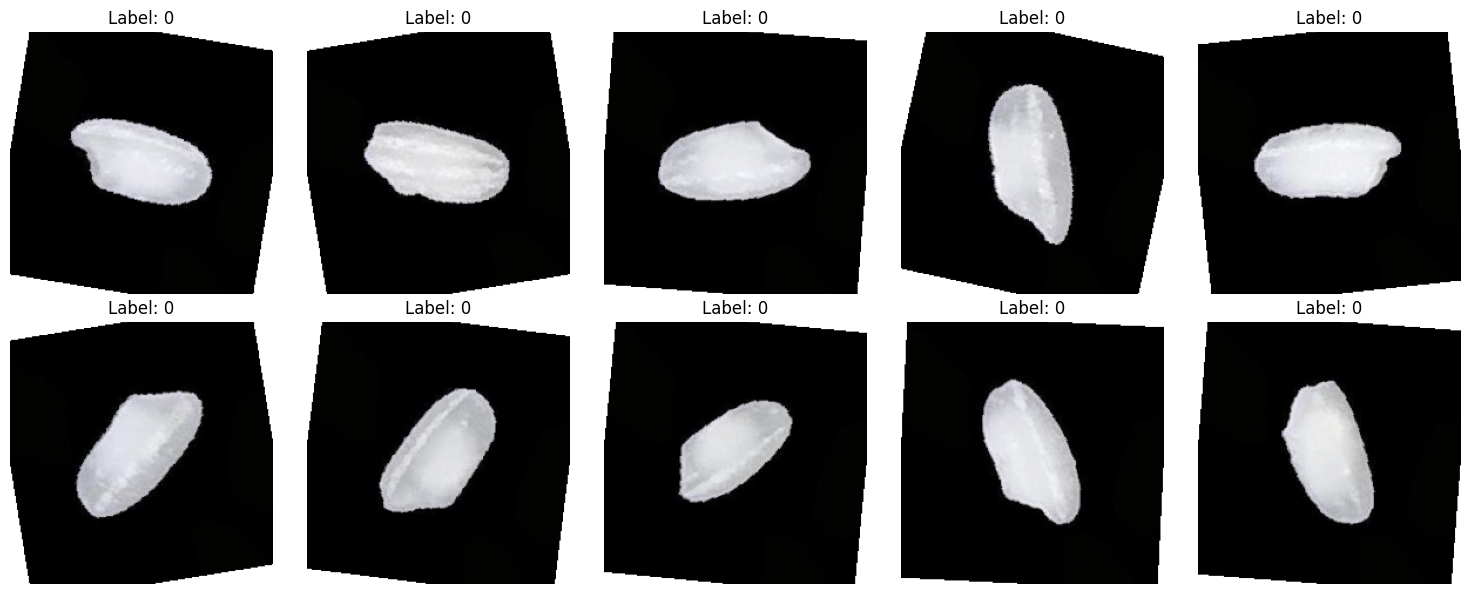

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

# 정규화 해제 (시각화용)
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# 이미지 10장 시각화
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    img_tensor, label = train_dataset[i]  # transform까지 적용됨
    img_tensor = inv_normalize(img_tensor)  # 정규화 해제
    img_np = img_tensor.permute(1, 2, 0).clamp(0, 1).numpy()  # [C,H,W] → [H,W,C]

    ax = axs[i // 5][i % 5]
    ax.imshow(img_np)
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
rn50_P = resnet50(weights=ResNet50_Weights.DEFAULT)
rn50_P.fc = nn.Sequential(nn.Linear(in_features=rn50_P.fc.in_features, out_features=5))
for param in rn50_P.parameters():
    param.requires_grad = False

for param in rn50_P.fc.parameters():
    param.requires_grad = True

rn50_P = rn50_P.to(device)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = Adam(params=rn50_P.parameters(), lr=0.001)

In [ ]:
import time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

start_time = timer()

rn_in_result = train_process(model=rn50_P,train_dataloader=train_loader,optimizer=optim,loss_fn=loss_fn,epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2213 | train_acc: 0.9500
Epoch: 2 | train_loss: 0.0882 | train_acc: 0.9739
Epoch: 3 | train_loss: 0.0708 | train_acc: 0.9780
Epoch: 4 | train_loss: 0.0653 | train_acc: 0.9791
Epoch: 5 | train_loss: 0.0573 | train_acc: 0.9813
Epoch: 6 | train_loss: 0.0557 | train_acc: 0.9813
Epoch: 7 | train_loss: 0.0534 | train_acc: 0.9823
Epoch: 8 | train_loss: 0.0525 | train_acc: 0.9825
Epoch: 9 | train_loss: 0.0493 | train_acc: 0.9839
Epoch: 10 | train_loss: 0.0463 | train_acc: 0.9842
Total Training Time: 1685.432 seconds


In [ ]:
test_step(model=rn50_P, dataloader=test_loader, loss_fn=loss_fn)

(0.0338098462530797, 0.9879397654584222)

초반에는 검은색으로 패딩을 했을 때 보다 더 낮은 점수로 시작을 하지만 계속해서 훈련을 하면 모델의 성능은 비슷하다. 모델이 흰 부분은 상관 없다고  판단하는 것 같다. 결론적으론 모델의 훈련 시간 비용 적인 측면에서는 이점이 있다. 끝쪽의 색에 따라 패딩의 색을 바꿔주면 훈련의 속도가 빨라진다고 판단 할 수 있다.

